In [84]:
!pip install mmcif_pdbx
!pip install pandas-profiling

# mmCIF / Protein Libs
import pdbx
from pdbx.reader import PdbxReader
from pdbx.reader import DataContainer

# I/O Libs
from google.cloud import storage
import io
import os
from IPython.display import clear_output

# Data Manipulation Libs
import pandas as pd
import numpy as np
import math
import random
import gzip

# Viz Libs
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns; sns.set()

# ML Libs
from sklearn import preprocessing
from sklearn.cluster import KMeans

clear_output()

In [85]:
# Instantiates a client & loads credentials
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = "PSS GCS Storage Key.json"
storage_client = storage.Client()

In [86]:
filenames = []
blob_list = storage_client.get_bucket('capstone-fall21-protein').list_blobs()
for blob in blob_list:
    if 'UP000005640_9606_HUMAN/cif/' in blob.name:
        filenames.append(blob.name)
print(f'Indexed {len(filenames)} files.')

Indexed 23391 files.


In [87]:
data=[]
stats = [0, 0]
result = []
alias = 'tmp.cif.gz'

for file in random.sample(filenames, 10):
    blob = storage_client.get_bucket('capstone-fall21-protein').get_blob(file)
    blob.download_to_filename(alias)

    with gzip.open(alias) as f:
        file_content = f.read()

    txt = io.StringIO(file_content.decode("utf-8"))

    stats[0] += 1
    pRd = PdbxReader(txt)
    pRd.read(data)
    txt.close()
    block = data[0]

    obj = block.get_object("atom_site")

    for row in obj.get()[2]:
        result.append(row)

    stats[1] += len(obj.get()[2])

os.remove(alias)
print(f'Processed {stats[0]} proteins ({stats[1]} rows).')

Processed 10 proteins (185920 rows).


In [88]:
atoms = pd.DataFrame(data=result, columns=obj.item_name_list, dtype=float)
atoms.sample(10)

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3441: FutureWarning: Could not cast to float64, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised
  exec(code_obj, self.user_global_ns, self.user_ns)


,_atom_site.group_PDB,_atom_site.id,_atom_site.type_symbol,_atom_site.label_atom_id,_atom_site.label_alt_id,_atom_site.label_comp_id,_atom_site.label_asym_id,_atom_site.label_entity_id,_atom_site.label_seq_id,_atom_site.pdbx_PDB_ins_code,...,_atom_site.pdbx_formal_charge,_atom_site.auth_seq_id,_atom_site.auth_comp_id,_atom_site.auth_asym_id,_atom_site.auth_atom_id,_atom_site.pdbx_PDB_model_num,_atom_site.pdbx_sifts_xref_db_acc,_atom_site.pdbx_sifts_xref_db_name,_atom_site.pdbx_sifts_xref_db_num,_atom_site.pdbx_sifts_xref_db_res
172630,ATOM,5303.0,N,ND1,,HIS,A,1.0,641.0,NaN,...,NaN,641.0,HIS,A,ND1,1.0,Q5VU43,UNP,641.0,H
42598,ATOM,5415.0,N,N,,GLU,A,1.0,656.0,NaN,...,NaN,656.0,GLU,A,N,1.0,Q5VU43,UNP,656.0,E
106462,ATOM,13503.0,O,OD1,,ASN,A,1.0,1689.0,NaN,...,NaN,1689.0,ASN,A,OD1,1.0,Q5VU43,UNP,1689.0,N
83608,ATOM,9241.0,N,N,,ILE,A,1.0,1146.0,NaN,...,NaN,1146.0,ILE,A,N,1.0,Q5VU43,UNP,1146.0,I
5989,ATOM,5990.0,C,CA,,LYS,A,1.0,732.0,NaN,...,NaN,732.0,LYS,A,CA,1.0,Q5VU43,UNP,732.0,K
44088,ATOM,6905.0,N,N,,GLN,A,1.0,849.0,NaN,...,NaN,849.0,GLN,A,N,1.0,Q5VU43,UNP,849.0,Q
113358,ATOM,1807.0,N,N,,GLU,A,1.0,217.0,NaN,...,NaN,217.0,GLU,A,N,1.0,Q5VU43,UNP,217.0,E
56465,ATOM,690.0,O,OD1,,ASN,A,1.0,80.0,NaN,...,NaN,80.0,ASN,A,OD1,1.0,Q5VU43,UNP,80.0,N
53305,ATOM,16122.0,C,CG,,TYR,A,1.0,2020.0,NaN,...,NaN,2020.0,TYR,A,CG,1.0,Q5VU43,UNP,2020.0,Y
7203,ATOM,7204.0,C,CA,,SER,A,1.0,885.0,NaN,...,NaN,885.0,SER,A,CA,1.0,Q5VU43,UNP,885.0,S


In [89]:
X = atoms[['_atom_site.Cartn_x', '_atom_site.Cartn_y', '_atom_site.Cartn_z']].copy(deep=True)
X.to_numpy()
X = preprocessing.StandardScaler().fit(X).transform(X)

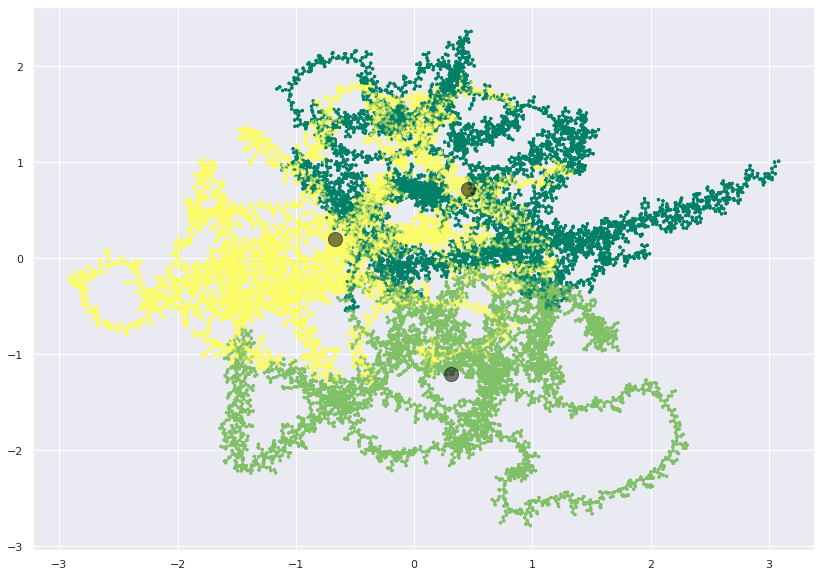

In [90]:
kmeans = KMeans(n_clusters=3, random_state=42).fit(X)
y_kmeans = kmeans.predict(X)

figure(figsize=(14,10))
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=5, cmap='summer', alpha=0.3)
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);